## Professional linear Regression with Scikit-learn

Here I am, going back to this dataset I picked some time ago (probably did this in San Antonio)

In [26]:
# Standard library
from pathlib import Path

# Data Science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning

# scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# misc
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error

In [2]:
path = Path('/kaggle/input/graduate-admissions/Admission_Predict.csv')
data = pd.read_csv(path)
data.rename(columns={'Chance of Admit ': 'Chance of Admit', 'LOR ': 'LOR'}, inplace=True)

print(data.tail())
print("--------------")
print(data.describe())
print("--------------")
print(data.info())

     Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR  CGPA  \
395         396        324          110                  3  3.5  3.5  9.04   
396         397        325          107                  3  3.0  3.5  9.11   
397         398        330          116                  4  5.0  4.5  9.45   
398         399        312          103                  3  3.5  4.0  8.78   
399         400        333          117                  4  5.0  4.0  9.66   

     Research  Chance of Admit  
395         1             0.82  
396         1             0.84  
397         1             0.91  
398         0             0.67  
399         1             0.95  
--------------
       Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count  400.000000  400.000000   400.000000         400.000000  400.000000   
mean   200.500000  316.807500   107.410000           3.087500    3.400000   
std    115.614301   11.473646     6.069514           1.143728    1.006869   
min      1

In [3]:
for col in data.columns:
    print("Min and max values of column {} are: min={}; max={}".format(col, data[col].min(), data[col].max()))

Min and max values of column Serial No. are: min=1; max=400
Min and max values of column GRE Score are: min=290; max=340
Min and max values of column TOEFL Score are: min=92; max=120
Min and max values of column University Rating are: min=1; max=5
Min and max values of column SOP are: min=1.0; max=5.0
Min and max values of column LOR are: min=1.0; max=5.0
Min and max values of column CGPA are: min=6.8; max=9.92
Min and max values of column Research are: min=0; max=1
Min and max values of column Chance of Admit are: min=0.34; max=0.97


## Okay, so all of the features are either ints or floats, making it easier for us (no need to handle categorical variables)


So, what do we need to do? We already know that there are no missing values. Let's understand the ranges of values we see for each feature and a breakdown of what each is.

'Serial No.': this one can be safely removed, as it's just a numerical value that goes from 0 to the nth row <br>
'GRE Score': in the hundreds range <br>
'TOEFL Score': again, in the hundreds range <br> 
'University Rating': goes from 1 to 5. The question in my head (and I think it's the correct one), how was this defined? What features makes a university 1 or a 5? Also, clearly we need to use some kind of scaling because the features have pretty different ranges <br>
'SOP': same <br>
'LOR': same <br>
'CGPA': scale in the tens <br>
'Research': a binary variable of whether the person has done research or not, nothing as to the quality of the research etc
'Chance of Admit': probability from 0.34 to 0.97

### Let's keep that in mind, but continue to doing EDA for now

   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR  CGPA  \
0           1        337          118                  4  4.5  4.5  9.65   
1           2        324          107                  4  4.0  4.5  8.87   
2           3        316          104                  3  3.0  3.5  8.00   
3           4        322          110                  3  3.5  2.5  8.67   
4           5        314          103                  2  2.0  3.0  8.21   

   Research  Chance of Admit  
0         1             0.92  
1         1             0.76  
2         1             0.72  
3         1             0.80  
4         0             0.65  
--------------
                   Serial No.  GRE Score  TOEFL Score  University Rating  \
Serial No.           1.000000  -0.097526    -0.147932          -0.169948   
GRE Score           -0.097526   1.000000     0.835977           0.668976   
TOEFL Score         -0.147932   0.835977     1.000000           0.695590   
University Rating   -0.169948   0.6689

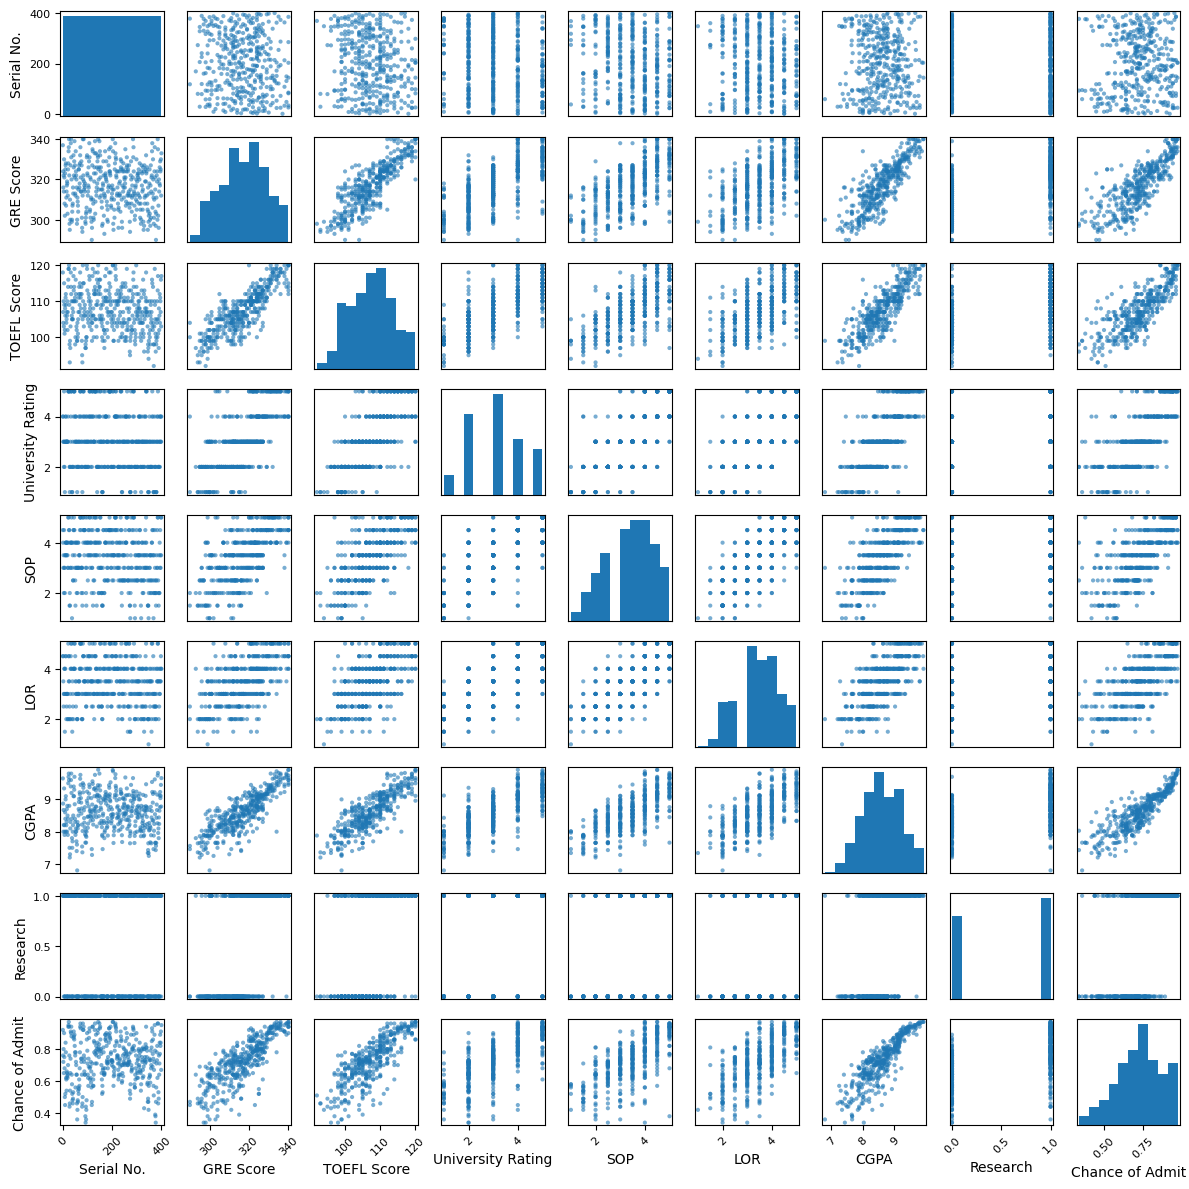

In [4]:
data_eda = data.copy()
print(data_eda.head(), end='\n')
print("--------------")
corr_matrix = data_eda.corr()
print(corr_matrix, end='\n')

print("Interpreting correlation coefficients\n")

target_corr = corr_matrix["Chance of Admit"].abs()
target_corr = target_corr.drop("Chance of Admit")
K = 10
top_k = target_corr.sort_values(ascending=False).head(K)
print(f"Top {K} features by |corr| with Chance of Admit:\n", top_k, end='\n')

print("--------------")

axes = pd.plotting.scatter_matrix(
    data_eda,
    figsize=(12, 12),
    diagonal='hist',
    alpha=0.6,
)

n = axes.shape[0]

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        # Bottom row → rotate X labels 45° and right-align
        if i == n - 1:
            ax.tick_params(
                axis='x',
                labelrotation=45,
                labelsize=8,
                labelbottom=True
            )
        else:
            ax.tick_params(
                axis='x',
                labelbottom=False  # hide intermediate x-labels
            )

        # First column → keep Y labels horizontal
        if j == 0:
            ax.tick_params(
                axis='y',
                labelrotation=0,
                labelsize=8,
                labelleft=True
            )
        else:
            ax.tick_params(
                axis='y',
                labelleft=False   # hide intermediate y-labels
            )

plt.tight_layout();

## First impressions


At a surface level, things are looking as expected. The categorical features are totally step wise, as can be seen. On the other hand, most numerical features like CGPA and GRE score are important factors obviously. University Rating is very positively correlated too, which is a surprising result to me. Even the categorical features showcase linear correlations in a different way though. Take CGPA versus SOP (or SOP versus CGPA, it's the same thing represented differently) for example. This is a categorical variable which represents the strength the applicant's application essays. There are 5 possible values, 1 through 5, so you see a pool of values for each possible values; **however**, as we go to higher and higher SOP strength values, CGPA climbs higher and higher.

Okay, everything falls into expectations so far. We don't need to do anything special to handle these categorical variables as they've already been convered to float64s for us, so let's get on with it!

### What we need to do

1. Divide data into train and test. Validation set will be handled by CV and grid search later. Drop the Serial No. feature
2. Scale the rest (compare StandardScaler, MinMaxScaler, and others if you wish). *If you have missing values in any column, add the imputer with the imputing strategy picked too* <br>
3. Do hyperparameter selection

Remember. When you have only transforms in your pipeline, you may use fit_transform. But when you add an estimator (SVR, LinearRegression) bit to the end of your pipeline, you will need to do fit() and then predict(), like normal ML code

In [5]:
# STEP 1

data_target = data['Chance of Admit']
data_features = data.drop(columns=['Chance of Admit', 'Serial No.'])
    
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data_target, test_size=0.30, random_state=42
)

In [6]:
# Confirmation that we have no missing values 

X_train.isna().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
dtype: int64

### Learnings about pipelines


My thinking was that I'd put everything into a pipeline, including all of the different models I wanted to test (Vanilla Regression (baseline), Ridge, SVR, and RandomForest), but it is not that easy.

If I want to do pre-processing in the beginning - which I do - I need to know that those modules need a fit_transform method which estimators don't have. So, something like:

```
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('plain_regression', LinearRegression(n_jobs=-1)),
    ('ridge_regression', Ridge(random_state=42)),
    ('svr', SVR(verbose=True)),
    ('forest', RandomForestRegressor(n_jobs=-1)),
])
```

would break at the ridge_regression step or so. That means, my hyperparameter grid needs to become more complex too; my initial plans were:

```
param_grid = {
    'ridge_regression__alpha': [],
    'ridge_regression__max_iter': [],
    'ridge_regression__solver': [],

    'svr__kernel': [],
    'svr__gamma': [],
    'svr__C': [],
    'svr__epsilon': [],
    'svr__max_iter': [],

    'forest__n_estimators': [],
    'forest__max_depth': [],
    'forest__min_samples_split': [],
    'forest__min_samples_leaf': []
}
```

## Picking values from scipy stats intervals to pass into RandomizedSearchCV. Let's explore!

If doing RandomizedSearchCV, which we are, every choice of the distribution we sample from has a significant effect. If we use uniform, all float values are equally likely. For exponential, most values are congregated around small values i.e. the probabilities rapidly decay, like the reverse exponential graph. This matterns when we're passing each one to the param_grid, depending on what range of values makes sense for each hyperparameter selection!

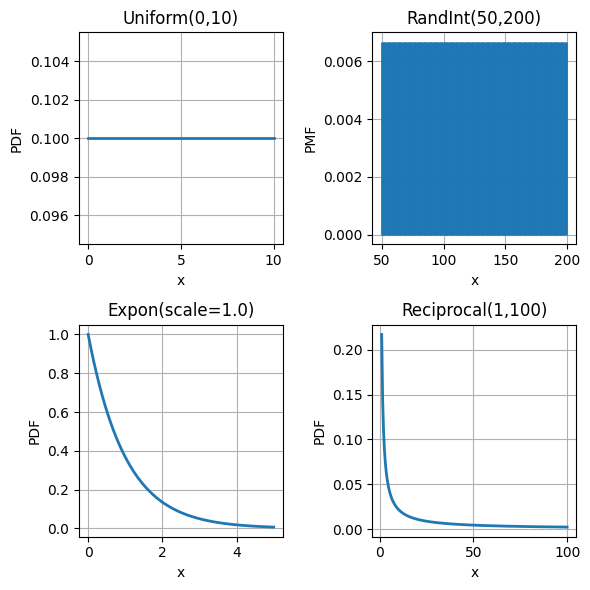

In [7]:
# Some extras to test out
from scipy.stats import expon, reciprocal 

# Define four distributions with typical hyperparameter ranges
distros = [
    ("Uniform(0,10)",         uniform(loc=0, scale=10), np.linspace(0, 10, 200)),
    ("RandInt(50,200)",       randint(50, 200),         np.arange(50, 201)),
    ("Expon(scale=1.0)",      expon(scale=1.0),         np.linspace(0, 5, 200)),
    ("Reciprocal(1,100)",     reciprocal(1, 100),       np.linspace(1, 100, 200)),
]

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for ax, (name, dist, x_vals) in zip(axs.ravel(), distros):
    if hasattr(dist, "pdf"):
        y = dist.pdf(x_vals)
        ax.plot(x_vals, y, lw=2)
        ax.set_ylabel("PDF")
    else:
        # randint uses pmf instead of pdf
        y = dist.pmf(x_vals)
        ax.vlines(x_vals, 0, y, lw=2)
        ax.set_ylabel("PMF")
    ax.set_title(name)
    ax.set_xlabel("x")
    ax.grid(True)

plt.tight_layout()
plt.show()

### How to run the hyperparameter selection cell?

An important thing to do is to use some sort of tqdm module or progress tracker, so you can see the verbose output. 

In [12]:
# STEP 2 and 3

pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('model', LinearRegression(n_jobs=-1)),
])

param_grid = [
    # 1) Plain OLS baseline
    {
      "model": [LinearRegression(n_jobs=-1)]
    },
    
    # 2) Ridge
    {
      "model":         [Ridge(random_state=42)],
      "model__alpha":  uniform(loc=0.0, scale=10.0),    # float in [0,10)
      "model__solver": ["auto","sag","lsqr"],
      "model__max_iter": randint(100, 2000)            # integer between 100 and 1999
    },
    
    # 3) SVR
    {
      "model":        [SVR(verbose=False)],
      "model__kernel": ["rbf","linear"],
      "model__C":      uniform(loc=1.0, scale=1000.0),  # float in [1,1001)
      "model__gamma":  expon(scale=0.1),                # decays from 0
      "model__epsilon": uniform(loc=0.01, scale=1.0),   # float in [0.01,1.01)
    },
    
    # 4) RandomForest
    {
      "model":                   [RandomForestRegressor(n_jobs=-1, random_state=42)],
      "model__n_estimators":     randint(50, 200),       # integer [50,199]
      "model__max_depth":        randint(5, 50),         # integer [5,49]
      "model__min_samples_split":[2,5,10],               # choose from these ints
      "model__min_samples_leaf": [1,2,4]                 # choose from these ints
    }
]

rnd_search = RandomizedSearchCV(
    estimator       = pipeline,
    param_distributions = param_grid,
    n_iter          = 20,           
    cv              = 3,            
    scoring         = "neg_mean_squared_error",
    n_jobs          = -1,
    verbose         = 2,            
    random_state    = 42,
    return_train_score=True
)

rnd_search.fit(X_train, y_train)
print("\nBest hyperparameters:")
print(rnd_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best hyperparameters:
{'model': Ridge(alpha=5.200680211778108, max_iter=1229, random_state=42, solver='sag'), 'model__alpha': 5.200680211778108, 'model__max_iter': 1229, 'model__solver': 'sag'}


In [24]:
best_estimator = rnd_search.best_estimator_
best_estimator

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 Ridge(alpha=5.200680211778108, max_iter=1229, random_state=42,
                       solver='sag'))])

In [23]:
results = pd.DataFrame(rnd_search.cv_results_)
is_baseline = results['param_model'].apply(lambda mod: isinstance(mod, LinearRegression))
print(results[is_baseline][['mean_train_score', 'mean_test_score']], end="\n\n")

best_idx = rnd_search.best_index_
best_row = results.iloc[best_idx][['mean_train_score', 'mean_test_score']]
best_row

    mean_train_score  mean_test_score
9          -0.003716        -0.004127
10         -0.003716        -0.004127
12         -0.003716        -0.004127
17         -0.003716        -0.004127



mean_train_score   -0.003725
mean_test_score    -0.004119
Name: 16, dtype: object

## Evaluation on cross-validation

We have to evaluate the best model we found through hyperparameter selection and RandomizedSearchCV and the results! Scores near 0.00(something), seems fishy to me. Let's try to see if this is overfitting or not. For this, we need to check the training scores in combination to the heldout validation set too!

Comparing the training and validation scores, they're really close; the mean_test_score (validation set) is slightly higher than mean_train_score, which totally makes sense logically. It seems to me that we're ready to pick the best performing model here, which is:


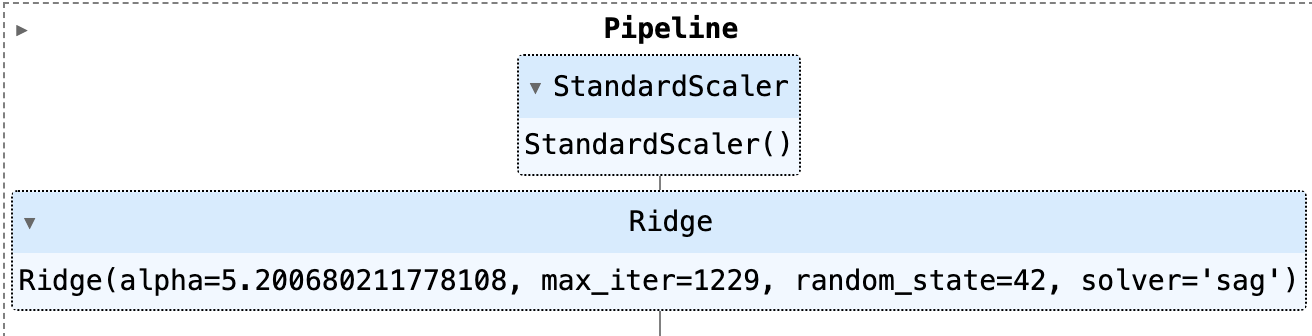

This Ridge model outperforms the baseline LinearRegression model modestly, showing you how well simple models can do, when everything fits (pun intended)!

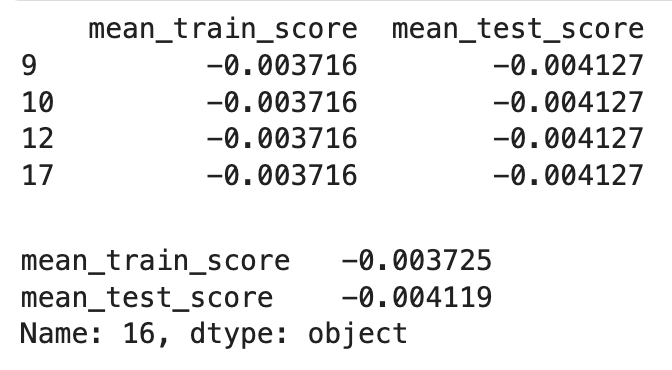
The one up top is the baseline, and the one below is the best Ridge model. The baseline does better in training (by a fraction of 0.000009) but the Ridge model generalizes better (by a fraction of 0.000008), so we will pick this estimator as our final model!

In [29]:
y_pred = rnd_search.predict(X_test)
rmse   = mean_squared_error(y_test, y_pred)
print(f"Final test MSE: {rmse:.4f}")

Final test MSE: 0.0047


## Final test performance

We get a MSE of 0.0047 which is worse by 0.00581 points only, so it's looking good! We have trained our model well, and it is ready to be used!

The future of this project is to actually use the model to see what kind of predictions it makes and analyze the results. To do so, we have two ideas:

1. Create a new row of the dataset from the internet that fits the admissions data collected
2. Find a wholly new set of data that ranges from Australian, Indian, US, British, any and all sort of college admissions data and test the model on that!
3. Get the errors to an even lower values by doing further analysis! (look for residuals within subgroups, perhaps do some clustering around errors?? OR retrain with fresh data because of ML models becoming stale over time)


These will be without ground truth values, but that's to be expected because when we test our models in the future, we won't have that.